In [3]:
import pandas as pd

In [4]:

df = pd.read_csv('iter.csv')


In [5]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGGTCTCCATGCGCG...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGCTCTTCG...


In [6]:
from tqdm import tqdm


In [7]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [8]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [9]:
import difflib


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [11]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 90502.73it/s]


[4, 14, 39, 60, 86, 122, 153, 181, 222, 256, 275, 325, 352, 366, 397, 405, 424, 477, 521, 543, 582, 611, 643, 674, 707, 711, 757, 794, 813, 841, 848, 924, 940, 942, 1018, 1030, 1037, 1101, 1127, 1158, 1171, 1232, 1230, 1255, 1299, 1327, 1365, 1376, 1368, 1451, 1509, 1541, 1541, 1558, 1612, 1631, 1653, 1678, 1709, 1727, 1818, 1817, 1794, 1886, 1913, 1944, 1924, 1955, 1992, 2021, 2069, 2032, 2091, 2156, 2170, 2220, 2202, 2237, 2314, 2318, 2352, 2386, 2425, 2442, 2481, 2476, 2481, 2539, 2614, 2567, 2603, 2694, 2683, 2745, 2761, 2829, 2746, 2802, 2881, 2944, 2935, 2944, 3047, 3014, 3094, 3040, 3139, 3153, 3168, 3027]


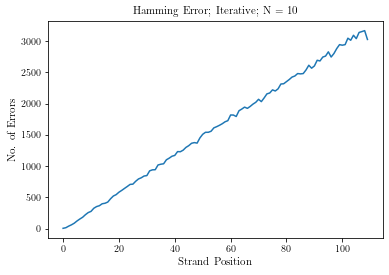

In [12]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-iter-hamming.pdf', bbox_inches='tight')

In [13]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:03<00:00, 2757.77it/s]


In [14]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> AG 6
A -> T 8
A -> C 9
C -> T 9
G -> T 11
G -> A 11
C -> G 11
C -> A 13
A -> G 14
T -> G 14
T -> C 17
T -> A 19
G -> C 22
G ->  92
C ->  100
A ->  105
T ->  108
 -> T 995
 -> G 1023
 -> C 1046
 -> A 1167


 -> T @ 80 6
 -> A @ 67 6
 -> G @ 71 6
 -> A @ 30 6
 -> C @ 72 6
 -> T @ 109 6
 -> T @ 5 6
 -> T @ 49 6
 -> C @ 32 6
 -> C @ 92 6
 -> G @ 43 6
 -> A @ 3 6
 -> A @ 53 6
 -> T @ 38 6
 -> C @ 80 6
 -> C @ 70 6
 -> C @ 87 6
 -> T @ 32 6
 -> G @ 82 6
 -> T @ 41 6
 -> T @ 103 6
 -> T @ 54 6
 -> G @ 64 6
 -> T @ 69 6
 -> T @ 88 6
 -> T @ 67 6
 -> A @ 97 6
 -> C @ 1 6
 -> G @ 96 6
 -> A @ 108 6
 -> A @ 16 6
 -> A @ 104 6
 -> C @ 54 6
 -> G @ 36 6
 -> G @ 11 6
 -> T @ 84 6
 -> T @ 78 6
 -> G @ 95 6
 -> G @ 40 7
 -> C @ 14 7
 -> A @ 95 7
 -> G @ 69 7
 -> G @ 84 7
 -> A @ 57 7
 -> C @ 77 7
 -> T @ 16 7
 -> G @ 56 7
 -> C @ 10 7
 -> G @ 62 7
 -> A @ 83 7
 -> G @ 65 7
 -> A @ 84 7
 -> C @ 100 7
 -> C @ 84 7
 -> C @ 79 7
 -> C @ 53 7
 -> A @ 100 7
 -> C @ 44 7
 -> T @ 85 7
 -> T @ 83 7
 -> T @ 71 7
 -> T @ 70 7
 -> T @ 7 7
 -> A @ 20 7
 -> G @ 107 7
 -> T @ 6 7
 -> T @ 58 7
 -> T @ 56 7
 -> T @ 52 7
 -> T @ 51 7
 -> A @ 28 7
 -> T @ 40 7
 -> G @ 2 7
 -> G @ 15 7
 -> G @ 16 7
 -> C @ 20 7
 -> G @ 25 

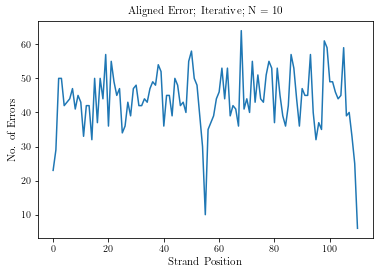

In [15]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-iter-aligned.pdf', bbox_inches='tight')

In [16]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [17]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [18]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[5, 8, 8, 6, 10, 14, 12, 8, 10, 8, 8, 11, 5, 8, 5, 10, 6, 17, 8, 16, 7, 20, 12, 13, 8, 9, 9, 8, 7, 12, 6, 9, 14, 9, 8, 9, 15, 9, 16, 19, 11, 10, 14, 12, 18, 8, 10, 8, 5, 12, 15, 18, 15, 6, 9, 2, 8, 7, 10, 13, 14, 8, 11, 20, 9, 10, 11, 6, 18, 9, 14, 10, 15, 12, 17, 13, 12, 16, 16, 5, 11, 9, 9, 7, 7, 9, 10, 18, 16, 15, 8, 9, 10, 14, 13, 7, 8, 6, 10, 17, 7, 12, 16, 10, 6, 12, 4, 13, 6, 8, 1]
[4, 6, 14, 13, 8, 9, 8, 12, 14, 10, 7, 9, 8, 9, 7, 14, 12, 9, 10, 13, 7, 3, 9, 9, 15, 4, 10, 9, 10, 9, 15, 8, 6, 11, 12, 8, 10, 10, 15, 11, 8, 14, 8, 10, 7, 11, 9, 9, 9, 15, 11, 8, 14, 7, 6, 0, 5, 8, 9, 10, 8, 18, 8, 5, 8, 8, 9, 8, 10, 16, 6, 9, 6, 10, 5, 14, 8, 7, 19, 7, 6, 16, 13, 5, 7, 10, 17, 6, 9, 5, 9, 10, 6, 10, 8, 9, 10, 8, 22, 11, 7, 9, 8, 16, 9, 10, 10, 9, 11, 5, 1]
[5, 4, 7, 13, 9, 8, 10, 14, 3, 8, 8, 6, 12, 11, 10, 7, 7, 8, 12, 11, 9, 11, 9, 11, 9, 7, 9, 10, 11, 11, 12, 10, 8, 13, 8, 13, 6, 12, 9, 12, 7, 10, 10, 6, 9, 9, 9, 12, 5, 13, 14, 11, 8, 9, 3, 2, 7, 8, 9, 9, 10, 10, 7, 8, 6, 7, 8, 

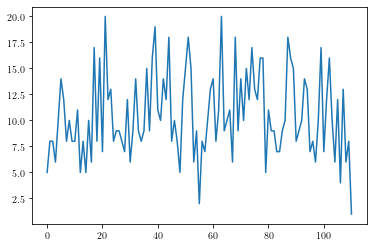

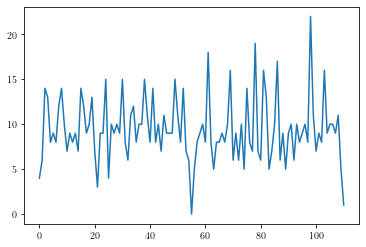

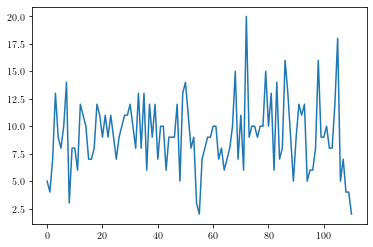

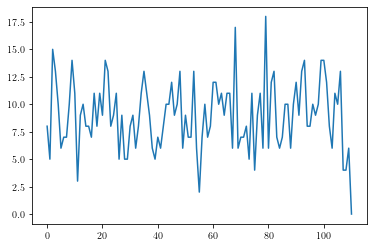

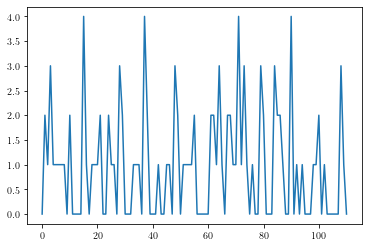

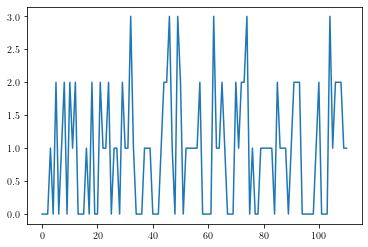

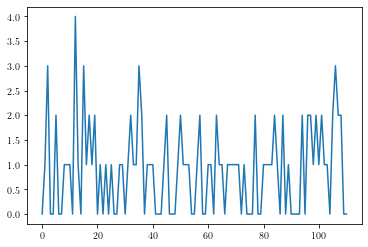

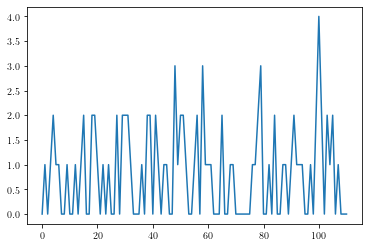

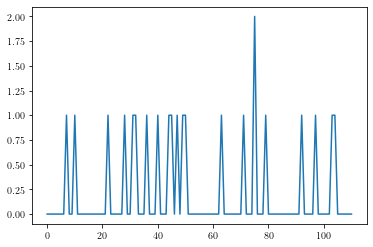

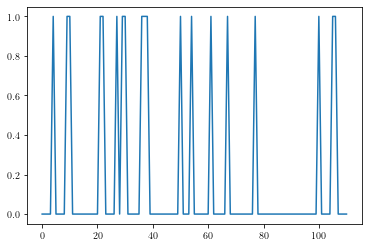

In [19]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [20]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)